In [1]:
from pandas import DataFrame, read_csv, to_numeric
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
# from pickle import load, dump
from bigml.api import BigML
import kaggle
from pprint import pprint
from os import path # vérifié l'existance des fichiers
import json

%matplotlib inline

We initialize the API with the name of the project

In [2]:
big_ml_project = 'project/5dc47429fb7bdd2dd90008ae'
api = BigML(project=big_ml_project)

# we prepare the file name with the project and the version

In [3]:
project = 'gmsc'
version = 'learning_curve'
dossier = 'learning_curve/'
#jar_filename = project + '-' + version + '-picklejar'
json_filename = project + '_' + version + '.json'

# We create our backup and file loading functions

If we want use json : 

In [4]:
def data_save(project_data):
    with open(dossier+json_filename, 'w') as file:
        json.dump(project_data, file)
        
def data_load():
    if path.exists(dossier+json_filename):
        with open(dossier+json_filename, 'r') as file:
            project_data = json.load(file)
        return project_data
    return {}
    

If we want use pickle : 

We load our data

In [5]:
project_data = data_load()

In [6]:
project_data['fulltrain file']='cs-train.csv'
project_data['test file']='cs-test.csv'

In [7]:
fulltrain=read_csv('./cs-training.csv',index_col=0)

# We realize the split

In [8]:
fixed_seed=12345
train, dev = train_test_split(fulltrain, test_size=0.2, random_state=fixed_seed)
dev_filename = dossier + project + '-' + version + '_dev' + '.csv.bz2' # pour compresser automatiquement .bz2 ! Pas compatible bachprediction
dev.to_csv(dev_filename,index_label='Id')
train_filename = dossier + project + '-' + version + '_train' + '.csv.bz2'
train.to_csv(train_filename,index_label='Id')
project_data['developpement file'] = dev_filename
len(train)

120000

We initialize our dictionaries

In [9]:
if 'models' not in project_data:
    project_data['models']={}
if 'train sources' not in project_data:
    project_data['train sources']={}
if 'train datasets' not in project_data:
    project_data['train datasets']={}

In [10]:
data_save(project_data)

We create sources and datasets

In [14]:
if 'developpement source' not in project_data:
    dev_src = api.create_source(dev_filename)
    api.ok(dev_src)
    project_data['developpement source']=dev_src['resource']
else:
    dev_src = api.get_source(project_data['developpement source'])
pprint(dev_src['resource'])

'source/5dc5aa255299631c82019991'


In [15]:
if 'developpement dataset' not in project_data:
    dev_ds = api.create_dataset(dev_src)
    api.ok(dev_ds)
    project_data['developpement dataset']=dev_ds['resource']
else:
    dev_ds = api.get_dataset(project_data['developpement dataset'])
pprint(dev_ds['resource'])

'dataset/5dc5a9cd7811dd7f2d019818'


In [16]:
pprint(project_data)

{'developpement dataset': 'dataset/5dc5a9cd7811dd7f2d019818',
 'developpement file': 'learning_curve/gmsc-learning_curve_dev.csv.bz2',
 'developpement source': 'source/5dc5aa255299631c82019991',
 'fulltrain file': 'cs-train.csv',
 'models': {},
 'test file': 'cs-test.csv',
 'train datasets': {},
 'train sources': {}}


We break up our training set

In [17]:
#training_sizes=[500,2000,5000,10000,25000,50000,100000,150000]
training_sizes=[int(120000*i/10) for i in range(1,11) ]
models=['ensemble','deepnet']

In [18]:
for size in training_sizes:
    train_filename = project + '_' + version + '_train_' + str(size) + '.csv.bz2'
    if not path.exists(train_filename):
        #if size < 120000:
        #    print(size)
        train_partial = train.sample(size)
        #else:
        #    train_partial = train
        train_partial.to_csv(train_filename, index_label='Id')
        
    if size not in project_data['train sources']:
        train_src = api.create_source(train_filename)
        api.ok(train_src)
        project_data['train sources'][size]=train_src['resource']
    else:
        train_src = api.get_source(project_data['train sources'][size])
        
    if size not in project_data['train datasets']:
        train_ds = api.create_dataset(train_src)
        api.ok(train_ds)
        project_data['train datasets'][size]=train_ds['resource']
    else:
        train_ds = api.get_dataset(project_data['train datasets'][size])

In [20]:
data_save(project_data)

We train our models

In [21]:
for size in training_sizes:
    for model_type in models:
        if size not in project_data['models']:
            project_data['models'][size]={}
        if model_type not in project_data['models'][size]:
            project_data['models'][size][model_type]={}
        model = project_data['models'][size][model_type]
        model['size'] = size
        model['model type'] = model_type
        model['train source'] = project_data['train sources'][size]
        model['train dataset'] = project_data['train datasets'][size]

In [22]:
model_args= {"objective_field": "SeriousDlqin2yrs"}
for size in project_data['models']:
    for model_type in project_data['models'][size]:
        print('Training ' + model_type + '_' + str(size))
        model_data = project_data['models'][size][model_type]
        train_ds = model_data['train dataset']
        if 'bigml model' not in model_data:
            if model_type == 'ensemble':
                
                model = api.create_ensemble(train_ds, model_args)
                api.ok(model)
                model_data['bigml model'] = model['resource']
            elif model_type == 'deepnet':
                model = api.create_deepnet(train_ds, model_args)
                api.ok(model)
                model_data['bigml model'] = model['resource']
        print('Done') 

Training ensemble_12000
Done
Training deepnet_12000
Done
Training ensemble_24000
Done
Training deepnet_24000
Done
Training ensemble_36000
Done
Training deepnet_36000
Done
Training ensemble_48000
Done
Training deepnet_48000
Done
Training ensemble_60000
Done
Training deepnet_60000
Done
Training ensemble_72000
Done
Training deepnet_72000
Done
Training ensemble_84000
Done
Training deepnet_84000
Done
Training ensemble_96000
Done
Training deepnet_96000
Done
Training ensemble_108000
Done
Training deepnet_108000
Done
Training ensemble_120000
Done
Training deepnet_120000
Done


In [23]:
data_save(project_data)

We create the evaluations

In [25]:
for size in project_data['models']:
    for model_type in project_data['models'][size]:
        print('Evaluating ' + model_type + '_' + str(size))
        model_data = project_data['models'][size][model_type]
        if model_type == 'ensemble':
            model = api.get_ensemble(model_data['bigml model'])
        if model_type == 'deepnet':
            model = api.get_deepnet(model_data['bigml model'])
        if 'dev evaluation' not in model_data:
            evaluation = api.create_evaluation(model, project_data['developpement dataset'])
            api.ok(evaluation)
            model_data['dev evaluation'] = evaluation['resource']
        if 'train evaluation' not in model_data:
            evaluation = api.create_evaluation(model, model_data['train dataset'])
            api.ok(evaluation)
            model_data['train evaluation'] = evaluation['resource']
        print('Done')

Evaluating ensemble_12000
Done
Evaluating deepnet_12000
Done
Evaluating ensemble_24000
Done
Evaluating deepnet_24000
Done
Evaluating ensemble_36000
Done
Evaluating deepnet_36000
Done
Evaluating ensemble_48000
Done
Evaluating deepnet_48000
Done
Evaluating ensemble_60000
Done
Evaluating deepnet_60000
Done
Evaluating ensemble_72000
Done
Evaluating deepnet_72000
Done
Evaluating ensemble_84000
Done
Evaluating deepnet_84000
Done
Evaluating ensemble_96000
Done
Evaluating deepnet_96000
Done
Evaluating ensemble_108000
Done
Evaluating deepnet_108000
Done
Evaluating ensemble_120000
Done
Evaluating deepnet_120000
Done


In [26]:
pprint(project_data)
data_save(project_data)

{'developpement dataset': 'dataset/5dc5a9cd7811dd7f2d019818',
 'developpement file': 'learning_curve/gmsc-learning_curve_dev.csv.bz2',
 'developpement source': 'source/5dc5aa255299631c82019991',
 'fulltrain file': 'cs-train.csv',
 'models': {12000: {'deepnet': {'bigml model': 'deepnet/5dc5b1a4e47684746801af0c',
                                'dev evaluation': 'evaluation/5dc5b6cc7811dd7f2d019904',
                                'model type': 'deepnet',
                                'size': 12000,
                                'train dataset': 'dataset/5dc5aa7ee47684746801adf8',
                                'train evaluation': 'evaluation/5dc5b6dae47684746801af33',
                                'train source': 'source/5dc5aa7a5299631c820199a8'},
                    'ensemble': {'bigml model': 'ensemble/5dc5b1945299631c82019a52',
                                 'dev evaluation': 'evaluation/5dc5b6aee47684746801af30',
                                 'model type': 'ensemble',


We retrieve the results of the evaluations

In [33]:
deepnet_train_auc=[]
ensemble_train_auc=[]
deepnet_train_accuracy=[]
ensemble_train_accuracy=[]
deepnet_dev_auc=[]
ensemble_dev_auc=[]
deepnet_dev_accuracy=[]
ensemble_dev_accuracy=[]


for size in training_sizes:
    evaluation = api.get_evaluation(project_data['models'][size]['deepnet']['train evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    accuracy = evaluation['object']['result']['model']['accuracy']
    deepnet_train_auc.append(auc)
    deepnet_train_accuracy.append(accuracy)
    
    evaluation = api.get_evaluation(project_data['models'][size]['ensemble']['train evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    accuracy = evaluation['object']['result']['model']['accuracy']
    ensemble_train_auc.append(auc)
    ensemble_train_accuracy.append(accuracy)
    
    evaluation = api.get_evaluation(project_data['models'][size]['deepnet']['dev evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    accuracy = evaluation['object']['result']['model']['accuracy']
    deepnet_dev_auc.append(auc)
    deepnet_dev_accuracy.append(accuracy)
    
    evaluation = api.get_evaluation(project_data['models'][size]['ensemble']['dev evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    accuracy = evaluation['object']['result']['model']['accuracy']
    ensemble_dev_auc.append(auc)
    ensemble_dev_accuracy.append(accuracy)

We display the graphs

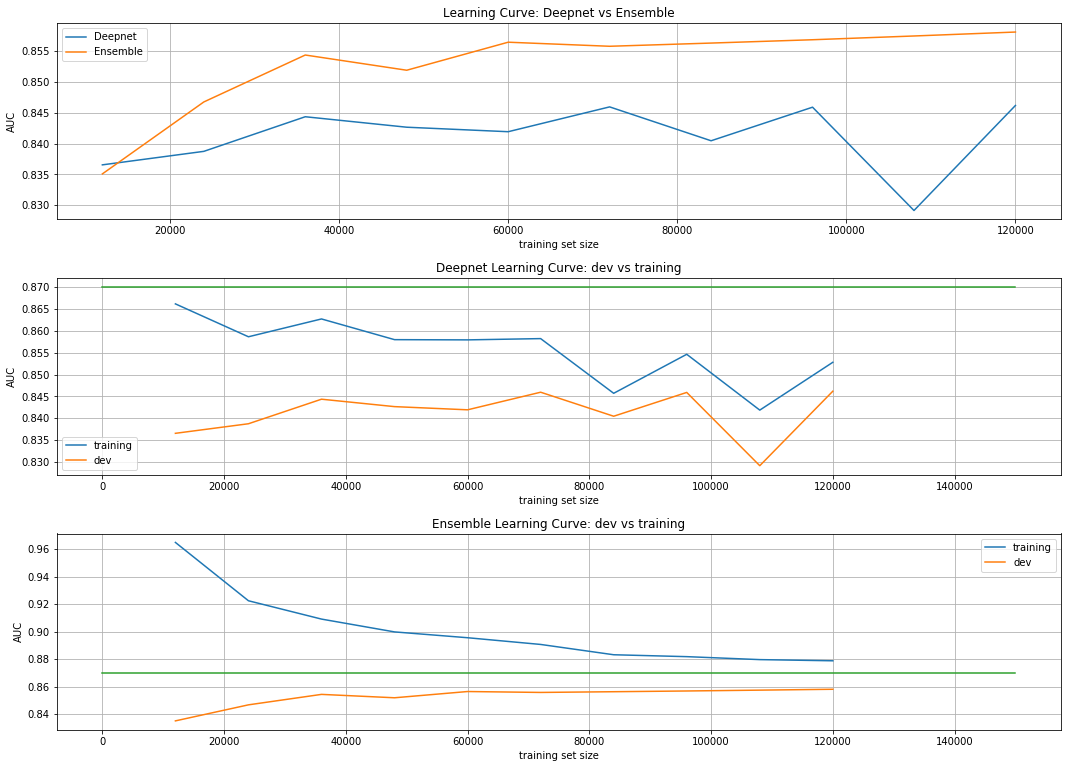

In [34]:
plt.subplots(3,1, figsize=(18, 13))
plt.subplots_adjust(hspace = 0.3)
plt.subplot(3,1,1)
plt.plot(training_sizes, deepnet_dev_auc, label="Deepnet")
plt.plot(training_sizes, ensemble_dev_auc, label="Ensemble")
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Learning Curve: Deepnet vs Ensemble')
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(training_sizes, deepnet_train_auc, label="training")
plt.plot(training_sizes, deepnet_dev_auc, label="dev")
plt.plot([0,150000],[0.87, 0.87])
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Deepnet Learning Curve: dev vs training')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(training_sizes, ensemble_train_auc, label="training")
plt.plot(training_sizes, ensemble_dev_auc, label="dev")
plt.plot([0,150000],[0.87, 0.87])
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Ensemble Learning Curve: dev vs training')
plt.grid()
plt.legend()
plt.show()